In [4]:
with open("youtube_data_vangogh_expanded.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# If top-level is a dict, show its keys
print("Top-level keys:", data.keys())

# Explore what's inside one of the keys
for key in data:
    print(f"\nSample records under key: {key}")
    print("Type:", type(data[key]))
    if isinstance(data[key], list) and len(data[key]) > 0:
        print("Keys in first record:", data[key][0].keys())
    break


Top-level keys: dict_keys(['youtube'])

Sample records under key: youtube
Type: <class 'list'>
Keys in first record: dict_keys(['video_id', 'title', 'channel_title', 'description', 'published_at', 'view_count', 'like_count', 'comment_count', 'hashtags', 'comments'])


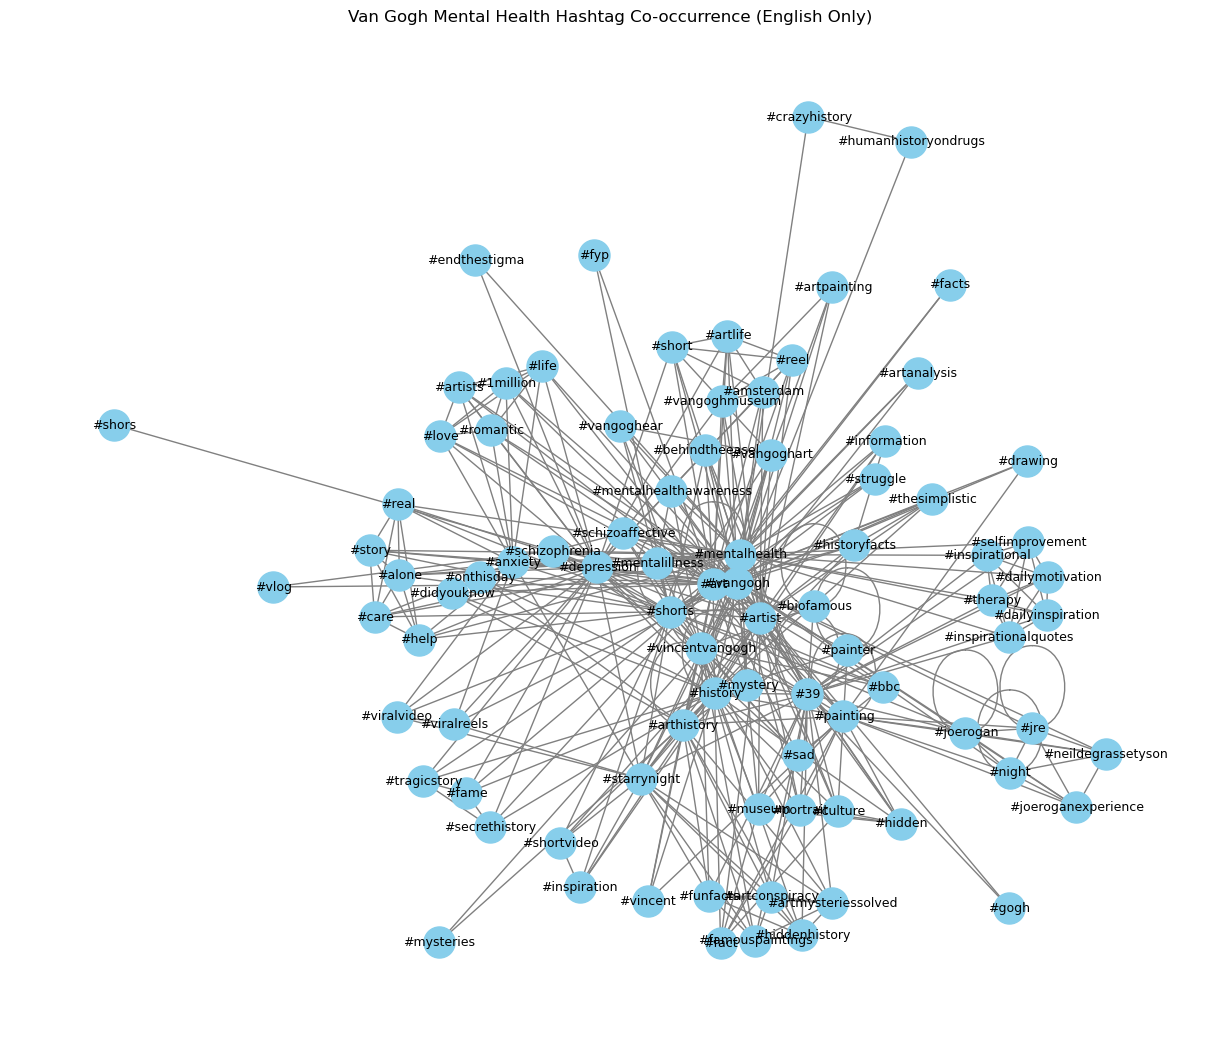

Avg. hashtags activated from seeds ['#mentalhealth', '#vangogh', '#depression']: 59.63


In [5]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random

# -----------------------------
# Step 1: Load and Extract Data
# -----------------------------
with open("youtube_data_vangogh_expanded.json", "r", encoding="utf-8") as f:
    data = json.load(f)

records = data["youtube"]  # Extract the list under "youtube"
df = pd.DataFrame(records)

# -----------------------------
# Step 2: Keep English-only Titles and Hashtags
# -----------------------------
def is_english(text):
    return all(ord(char) < 128 for char in text)

# Filter English titles
df = df[df['title'].apply(is_english)]

# Clean and filter hashtags
df['hashtags'] = df['hashtags'].apply(
    lambda tags: [tag.lower() for tag in tags if isinstance(tag, str) and tag.startswith('#') and is_english(tag)]
)

# Keep only videos with at least 2 hashtags (for co-occurrence)
df = df[df['hashtags'].map(len) > 1]

# -----------------------------
# Step 3: Build Co-occurrence Graph
# -----------------------------
G = nx.Graph()

for tags in df['hashtags']:
    for i in range(len(tags)):
        for j in range(i + 1, len(tags)):
            if G.has_edge(tags[i], tags[j]):
                G[tags[i]][tags[j]]['weight'] += 1
            else:
                G.add_edge(tags[i], tags[j], weight=1)

# -----------------------------
# Step 4: Visualize Hashtag Graph
# -----------------------------
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G, pos,
    node_size=500,
    with_labels=True,
    font_size=9,
    node_color='skyblue',
    edge_color='gray'
)
plt.title("Van Gogh Mental Health Hashtag Co-occurrence (English Only)")
plt.show()

# -----------------------------
# Step 5: Independent Cascade Model for Diffusion
# -----------------------------
def independent_cascade(graph, seeds, activation_prob=0.2, iterations=100):
    results = []
    for _ in range(iterations):
        active = set(seeds)
        new_active = set(seeds)
        while new_active:
            next_active = set()
            for node in new_active:
                for neighbor in graph.neighbors(node):
                    if neighbor not in active and random.random() < activation_prob:
                        next_active.add(neighbor)
            active.update(next_active)
            new_active = next_active
        results.append(len(active))
    return sum(results) / len(results)

# Define seed hashtags
seeds = ['#mentalhealth', '#vangogh', '#depression']

# Run diffusion simulation
spread = independent_cascade(G, seeds)
print(f"Avg. hashtags activated from seeds {seeds}: {spread:.2f}")


In [ ]:
#1. Identify Influential Hashtags
#Use centrality metrics like degree, betweenness, and eigenvector to find the most influential hashtags.

In [6]:
centrality = nx.betweenness_centrality(G)
top = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 influential hashtags (betweenness):")
for tag, score in top:
    print(f"{tag}: {score:.4f}")


Top 10 influential hashtags (betweenness):
#vangogh: 0.3125
#art: 0.1373
#39: 0.1162
#mentalhealth: 0.1121
#depression: 0.1005
#shorts: 0.0726
#vincentvangogh: 0.0627
#history: 0.0582
#artist: 0.0424
#arthistory: 0.0358


In [ ]:
#2. Community Detection (Topic Clusters)
#Use Louvain method to find hashtag clusters.


ERROR: Invalid requirement: '#'


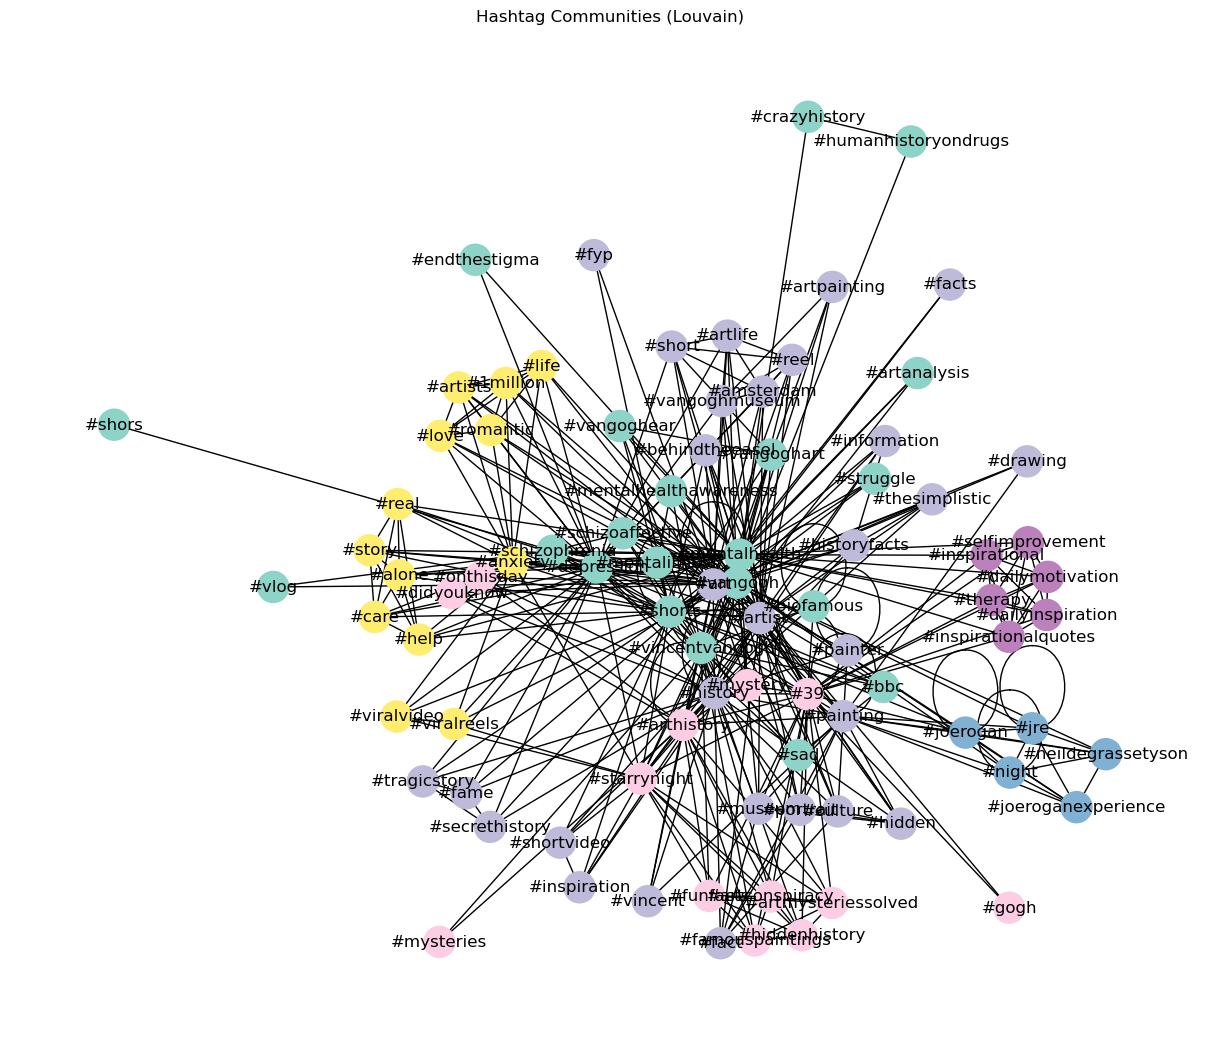

In [7]:
!pip install community  # First time only
import community as community_louvain

partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, 'community')

# Visualize with colors
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
colors = [partition.get(node) for node in G.nodes()]
nx.draw(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.Set3, node_size=500)
plt.title("Hashtag Communities (Louvain)")
plt.show()


In [88]:
nx.write_graphml(G, "van_gogh_hashtag_graph.graphml")

In [ ]:
# ForceAtlas 2 groups related hashtags naturally, forming clusters around central topics
# Eigenvector centrality highlights nodes that are well-connected to other well-connected nodes (e.g., #mentalhealth, #vangogh, etc.)

In [9]:
import networkx as nx
import pandas as pd

# Load GraphML exported from Gephi
G = nx.read_graphml("van_gogh_hashtag_graph.graphml")

# Compute betweenness centrality
bc = nx.betweenness_centrality(G)

# Convert to DataFrame
bc_df = pd.DataFrame(bc.items(), columns=["Id", "Betweenness"])

# Save to CSV to import in Gephi Data Laboratory
bc_df.to_csv("betweenness_scores.csv", index=False)


In [10]:
def independent_cascade(graph, seeds, activation_prob=0.2, iterations=100):
    results = []
    for _ in range(iterations):
        active = set(seeds)
        new_active = set(seeds)
        while new_active:
            next_active = set()
            for node in new_active:
                for neighbor in graph.neighbors(node):
                    if neighbor not in active and random.random() < activation_prob:
                        next_active.add(neighbor)
            active.update(next_active)
            new_active = next_active
        results.append(len(active))
    return sum(results) / len(results)

# Example:
spread = independent_cascade(G, ['#mentalhealth', '#vangogh'], 0.2)


In [11]:
centrality = nx.betweenness_centrality(G)

# Add as attribute to nodes
for node, value in centrality.items():
    G.nodes[node]['betweenness'] = value

# Export with centrality attribute
nx.write_graphml(G, "van_gogh_hashtag_graph_with_betweenness.graphml")


In [ ]:
# Identify spikes in conversation volume (e.g., number of comments or videos) about Van Gogh’s mental health around key dates:
# Van Gogh’s death anniversary → July 29
# World Mental Health Day → October 10

In [13]:
import pandas as pd
import json

# Load and extract the correct layer
with open("youtube_data_vangogh_expanded.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data['youtube'])  # Extract the "youtube" list into a DataFrame

# Now this will work
df['published_at'] = pd.to_datetime(df['published_at'])

# Optional: lowercase other fields for cleaning/filtering
df['title'] = df['title'].str.lower()



In [44]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load JSON
with open("youtube_data_vangogh_expanded.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data['youtube'])

# Helper: Check if mostly English
def is_english(text):
    return all(ord(char) < 128 for char in str(text))

# Keep English-only records
df = df[df['title'].apply(is_english)]
df = df[df['description'].apply(is_english)]
df = df[df['channel_title'].apply(is_english)]

# Clean hashtags
df['hashtags'] = df['hashtags'].apply(lambda tags: [
    tag.lower() for tag in tags if isinstance(tag, str) and tag.startswith('#') and is_english(tag)
])
df = df[df['hashtags'].map(len) > 0]

# Convert datetime
df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce')

# -----------------------------
# Step 2: Explode + Remove Noise
# -----------------------------
exploded_df = df.explode('hashtags')
exploded_df = exploded_df.dropna(subset=['published_at', 'hashtags'])

# Remove unwanted tags AFTER exploding
noisy_tags = ['#39', '#shorts']
exploded_df = exploded_df[~exploded_df['hashtags'].isin(noisy_tags)]

# Extract year-month
exploded_df['year_month'] = exploded_df['published_at'].dt.to_period('M')


C:\Users\seeya\AppData\Local\Temp\ipykernel_79180\1780951839.py:40: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  exploded_df['year_month'] = exploded_df['published_at'].dt.to_period('M')


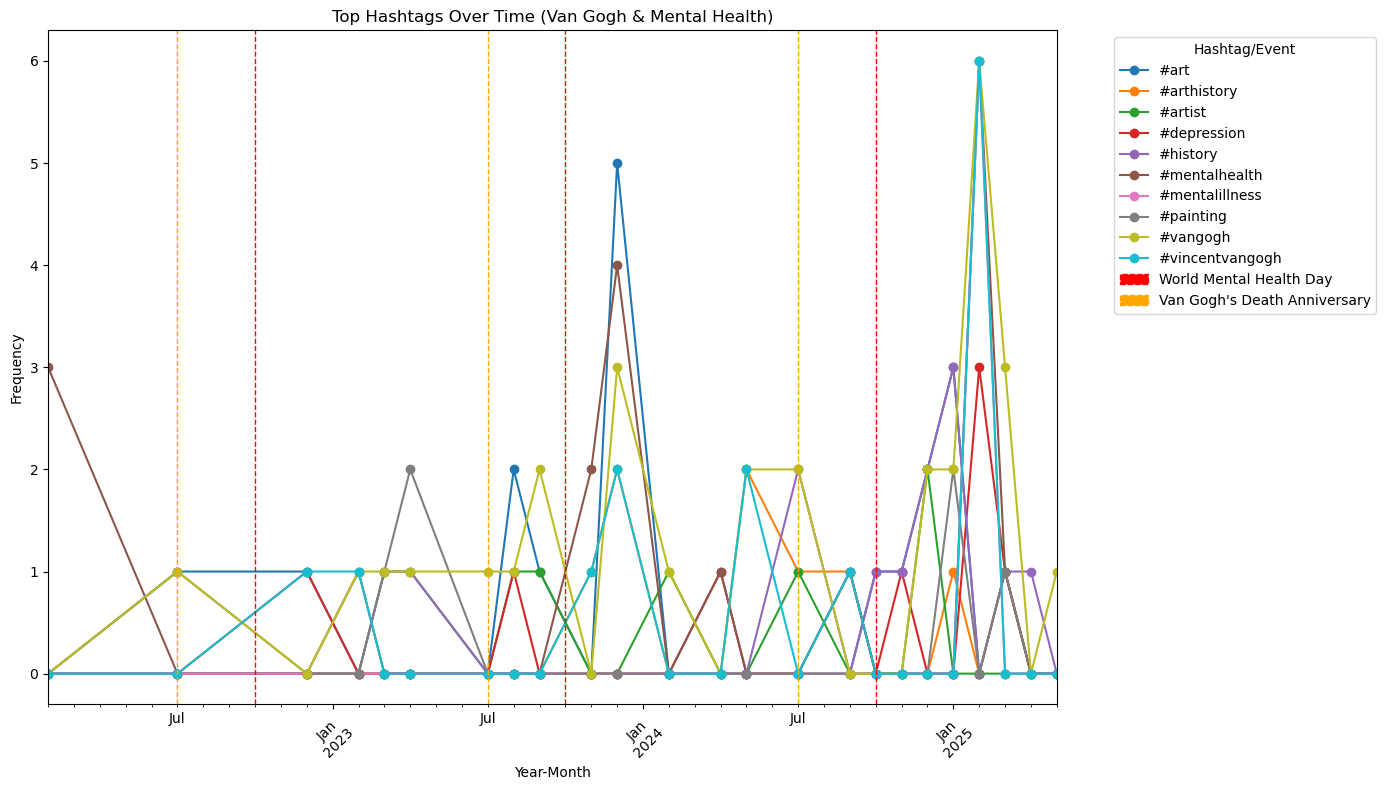

In [51]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# === Your data plot ===
plt.figure(figsize=(14, 8))
tag_time_counts.plot(ax=plt.gca(), marker='o')

# === Plot vertical event lines ===
# Mental Health Day lines (red dashed)
wmh_years = list(range(2016, 2025))
for year in wmh_years:
    plt.axvline(pd.Period(f"{year}-10", freq='M'), color='red', linestyle='--', linewidth=1)

# Van Gogh Death Anniversary lines (orange dashed)
death_years = list(range(2016, 2025))
for year in death_years:
    plt.axvline(pd.Period(f"{year}-07", freq='M'), color='orange', linestyle='--', linewidth=1)

# === Create proxy legend entries for event markers ===
mh_patch = mpatches.Patch(color='red', label='World Mental Health Day', linestyle='--')
death_patch = mpatches.Patch(color='orange', label="Van Gogh's Death Anniversary", linestyle='--')

# === Final legend ===
handles, labels = plt.gca().get_legend_handles_labels()
hashtag_legend = dict(zip(labels, handles))

# Combine hashtags + event markers into one legend
final_handles = list(hashtag_legend.values()) + [mh_patch, death_patch]
final_labels = list(hashtag_legend.keys()) + ["World Mental Health Day", "Van Gogh's Death Anniversary"]

plt.legend(final_handles, final_labels, bbox_to_anchor=(1.05, 1), loc='upper left', title='Hashtag/Event')
plt.title("Top Hashtags Over Time (Van Gogh & Mental Health)")
plt.xlabel("Year-Month")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Min date in dataset: 2022-02-14 23:49:19+00:00
Min year-month in grouped data: 2022-02


In [32]:
# Get first appearance date for each hashtag
first_use = exploded_df.groupby('hashtags')['published_at'].min().sort_values()
print(first_use.head(10))  # earliest-used hashtags

# Example: hashtags that emerged after 2022
late_hashtags = first_use[first_use > '2022-01-01'].index.tolist()
print("Hashtags appearing after 2022:", late_hashtags)


hashtags
#mentalhealth     2022-02-14 23:49:19+00:00
#10               2022-03-11 22:43:01+00:00
#painting         2022-07-08 13:59:32+00:00
#vangogh          2022-07-08 13:59:32+00:00
#drawing          2022-07-08 13:59:32+00:00
#art              2022-07-08 13:59:32+00:00
#sad              2022-12-01 00:53:52+00:00
#depression       2022-12-01 00:53:52+00:00
#bbc              2022-12-01 00:53:52+00:00
#vincentvangogh   2022-12-01 00:53:52+00:00
Name: published_at, dtype: datetime64[ns, UTC]
Hashtags appearing after 2022: ['#mentalhealth', '#10', '#painting', '#vangogh', '#drawing', '#art', '#sad', '#depression', '#bbc', '#vincentvangogh', '#vangoghart', '#vangoghear', '#history', '#culture', '#museum', '#hidden', '#portrait', '#artist', '#jre', '#joeroganexperience', '#neildegrassetyson', '#night', '#joerogan', '#fact', '#fyp', '#vangoghmuseum', '#amsterdam', '#short', '#artlife', '#reel', '#behindtheeasel', '#therapy', '#dailyinspiration', '#inspirationalquotes', '#selfimprovement', '

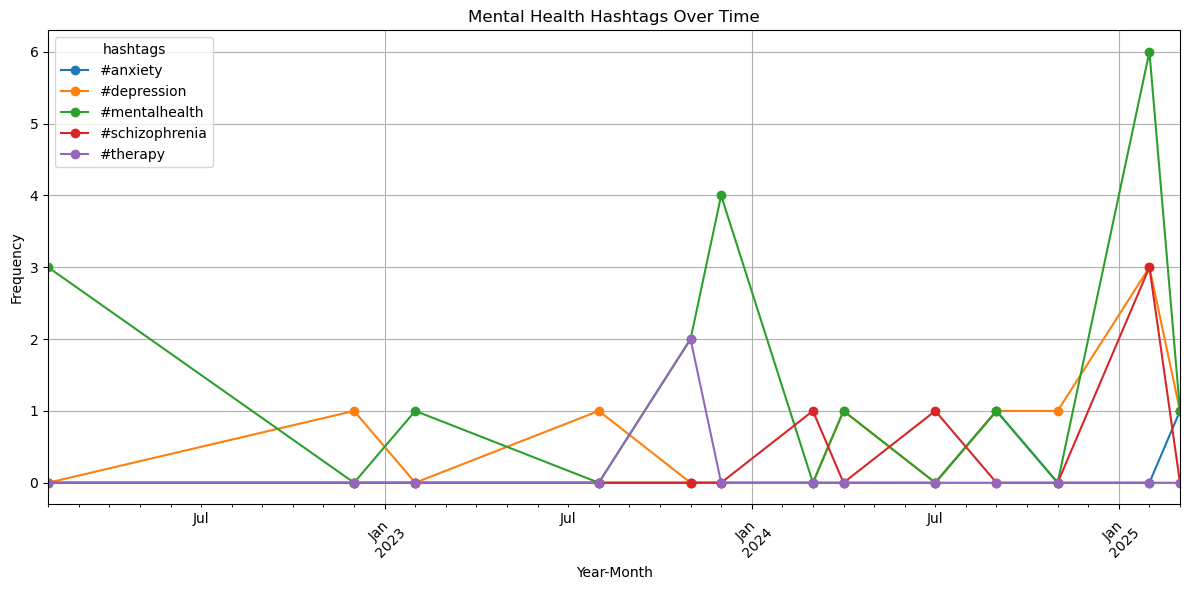

In [87]:
focus_tags = ['#mentalhealth', '#depression', '#anxiety', '#schizophrenia', '#therapy', '#VanGogh', 'painting']
focus_df = exploded_df[exploded_df['hashtags'].isin(focus_tags)]

# Group and plot
focus_counts = focus_df.groupby(['year_month', 'hashtags']).size().unstack(fill_value=0)
focus_counts.plot(marker='o', figsize=(12, 6))
plt.title("Mental Health Hashtags Over Time")
plt.ylabel("Frequency")
plt.xlabel("Year-Month")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
# Hashtags that appeared before and after 2022
early_hashtags = first_use[first_use <= '2022-01-01'].index.tolist()
late_hashtags = first_use[first_use > '2022-01-01'].index.tolist()
print("Early adopters:", early_hashtags)
print("Late adopters:", late_hashtags)


Early adopters: []
Late adopters: ['#mentalhealth', '#10', '#painting', '#vangogh', '#drawing', '#art', '#sad', '#depression', '#bbc', '#vincentvangogh', '#vangoghart', '#vangoghear', '#history', '#culture', '#museum', '#hidden', '#portrait', '#artist', '#jre', '#joeroganexperience', '#neildegrassetyson', '#night', '#joerogan', '#fact', '#fyp', '#vangoghmuseum', '#amsterdam', '#short', '#artlife', '#reel', '#behindtheeasel', '#therapy', '#dailyinspiration', '#inspirationalquotes', '#selfimprovement', '#dailymotivation', '#inspirational', '#arthistory', '#mysteries', '#facts', '#struggle', '#mystery', '#philosophaire', '#artpainting', '#schizophrenia', '#shors', '#endthestigma', '#biofamous', '#vlog', '#inspiration', '#starrynight', '#shortvideo', '#onthisday', '#didyouknow', '#famouspaintings', '#artmysteriessolved', '#artconspiracy', '#funfacts', '#hiddenhistory', '#alone', '#anxiety', '#story', '#help', '#care', '#real', '#tragicstory', '#fame', '#secrethistory', '#historyfacts', '#i

C:\Users\seeya\AppData\Local\Temp\ipykernel_79180\4061383386.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  hashtag_first_dates = hashtag_first_dates.dt.to_period('M')


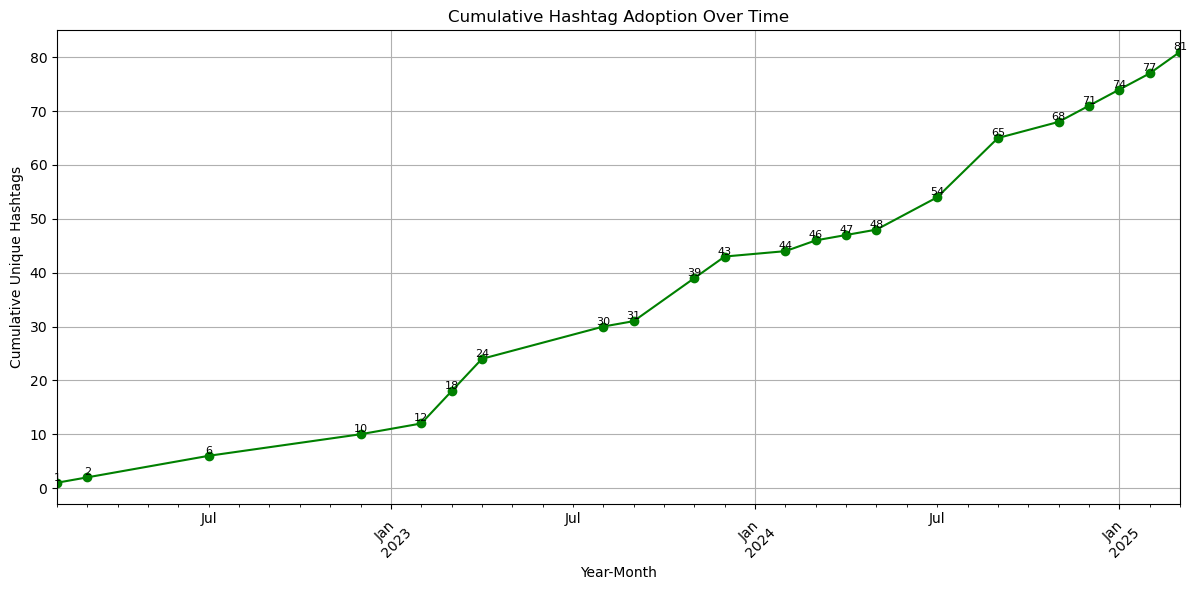

In [64]:
import matplotlib.pyplot as plt

# Step 1: Compute cumulative hashtag adoption
hashtag_first_dates = exploded_df.groupby('hashtags')['published_at'].min().dropna()
hashtag_first_dates = hashtag_first_dates.dt.to_period('M')
spread_df = hashtag_first_dates.value_counts().sort_index().cumsum()

# Step 2: Plot
fig, ax = plt.subplots(figsize=(12, 6))
spread_df.plot(kind='line', marker='o', color='green', ax=ax)
plt.title("Cumulative Hashtag Adoption Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Cumulative Unique Hashtags")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Step 3: Convert PeriodIndex to Timestamp for text annotations
for x, y in zip(spread_df.index.to_timestamp(), spread_df.values):
    ax.text(x, y, str(y), fontsize=8, ha='center', va='bottom')

plt.show()


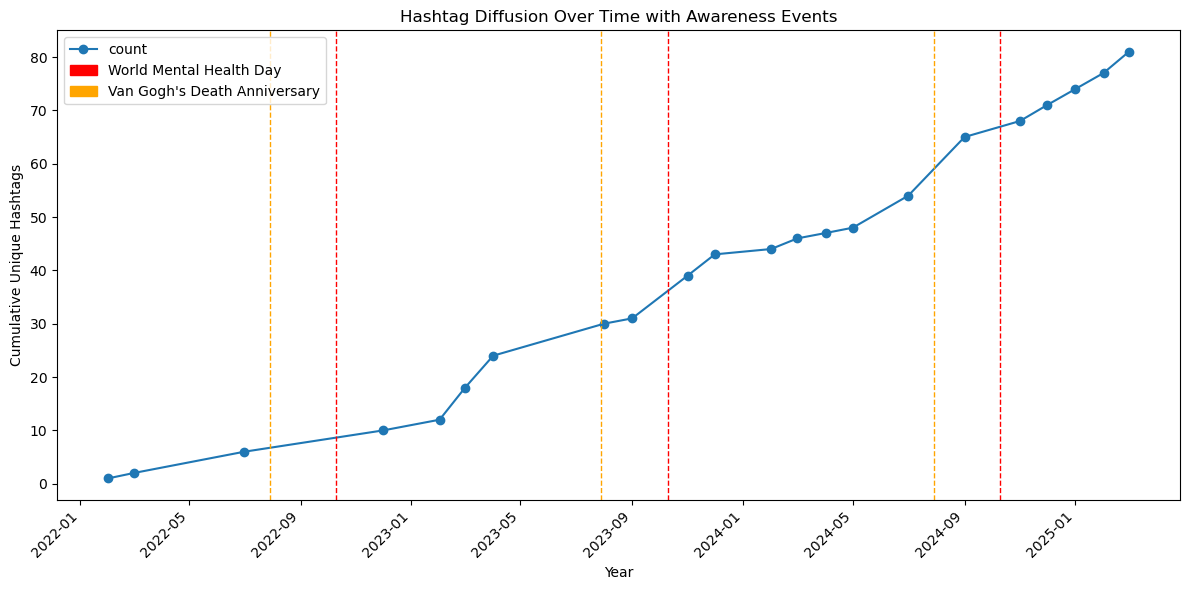

In [72]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Assume spread_df.index is already in datetime format
plt.figure(figsize=(12, 6))
spread_df.plot(marker='o', ax=plt.gca())

# Awareness events
for year in [2022, 2023, 2024]:
    plt.axvline(pd.Timestamp(f"{year}-10-10"), color='red', linestyle='--', linewidth=1)
    plt.axvline(pd.Timestamp(f"{year}-07-29"), color='orange', linestyle='--', linewidth=1)

# Custom legend handles
mh_patch = mpatches.Patch(color='red', label='World Mental Health Day')
death_patch = mpatches.Patch(color='orange', label="Van Gogh's Death Anniversary")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles + [mh_patch, death_patch], labels + ["World Mental Health Day", "Van Gogh's Death Anniversary"])

# Clean titles and labels
plt.title("Hashtag Diffusion Over Time with Awareness Events")
plt.xlabel("Year")
plt.ylabel("Cumulative Unique Hashtags")

# Remove grid and fix x-axis
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


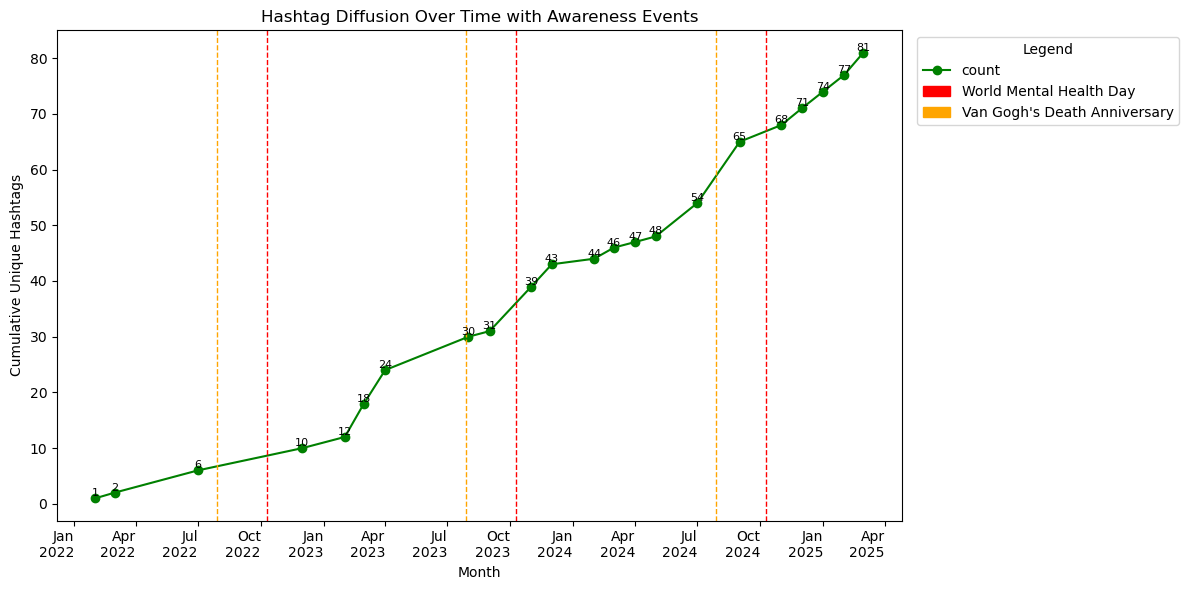

In [71]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib.dates as mdates

# Step 1: Make sure index is datetime
spread_df.index = pd.to_datetime(spread_df.index)

# Step 2: Plot
fig, ax = plt.subplots(figsize=(12, 6))
spread_df.plot(marker='o', ax=ax, color='green')

# Step 3: Awareness lines
for year in [2022, 2023, 2024]:
    ax.axvline(pd.Timestamp(f"{year}-10-10"), color='red', linestyle='--', linewidth=1)
    ax.axvline(pd.Timestamp(f"{year}-07-29"), color='orange', linestyle='--', linewidth=1)

# Step 4: Legend patches for event lines
mh_patch = mpatches.Patch(color='red', label='World Mental Health Day')
death_patch = mpatches.Patch(color='orange', label="Van Gogh's Death Anniversary")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles + [mh_patch, death_patch],
          labels + ["World Mental Health Day", "Van Gogh's Death Anniversary"],
          loc='upper left', bbox_to_anchor=(1.01, 1), title="Legend")

# Step 5: Annotate values
for x, y in zip(spread_df.index, spread_df.values):
    ax.text(x, y, str(y), fontsize=8, ha='center', va='bottom')

# Step 6: X-axis format fix
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format like "Jan 2023"
plt.xticks(rotation=0)  # Keep x-axis labels horizontal

# Final touches
ax.set_title("Hashtag Diffusion Over Time with Awareness Events")
ax.set_xlabel("Month")
ax.set_ylabel("Cumulative Unique Hashtags")
plt.grid(False)
plt.tight_layout()
plt.show()


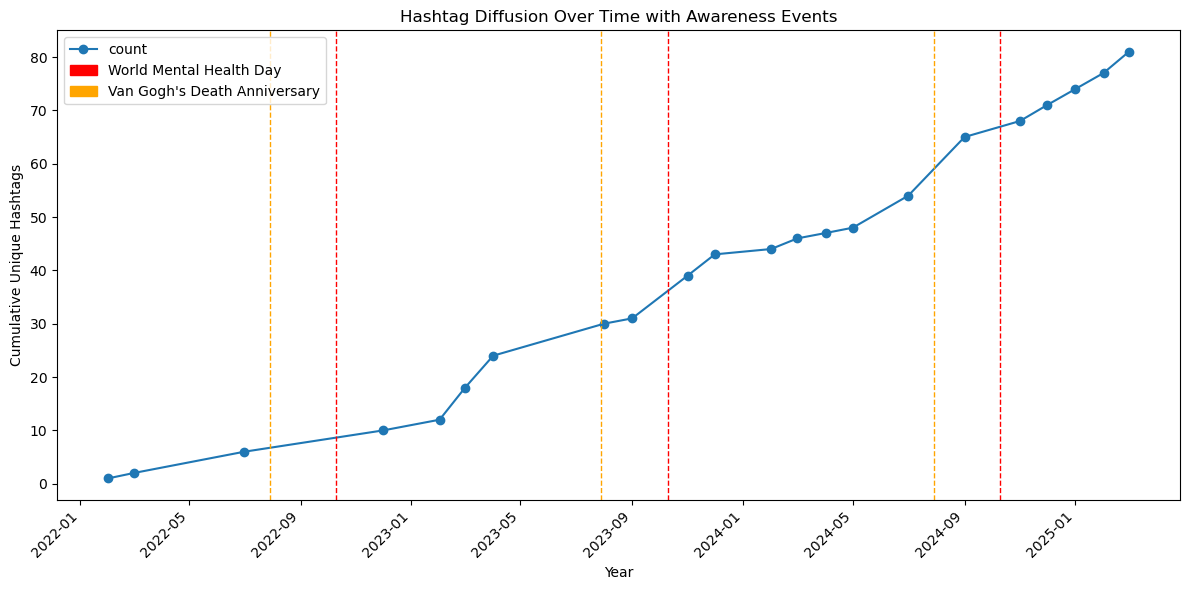

In [66]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Assume spread_df.index is already in datetime format
plt.figure(figsize=(12, 6))
spread_df.plot(marker='o', ax=plt.gca())

# Awareness events
for year in [2022, 2023, 2024]:
    plt.axvline(pd.Timestamp(f"{year}-10-10"), color='red', linestyle='--', linewidth=1)
    plt.axvline(pd.Timestamp(f"{year}-07-29"), color='orange', linestyle='--', linewidth=1)

# Custom legend handles
mh_patch = mpatches.Patch(color='red', label='World Mental Health Day')
death_patch = mpatches.Patch(color='orange', label="Van Gogh's Death Anniversary")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles + [mh_patch, death_patch], labels + ["World Mental Health Day", "Van Gogh's Death Anniversary"])

# Clean titles and labels
plt.title("Hashtag Diffusion Over Time with Awareness Events")
plt.xlabel("Year")
plt.ylabel("Cumulative Unique Hashtags")

# Remove grid and fix x-axis
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [73]:
# Make sure 'published_at' is datetime
exploded_df['published_at'] = pd.to_datetime(exploded_df['published_at'])

# Extract month
exploded_df['year_month'] = exploded_df['published_at'].dt.to_period('M')

# Count usage per hashtag per month
hashtag_month_counts = exploded_df.groupby(['year_month', 'hashtags']).size().unstack(fill_value=0)


C:\Users\seeya\AppData\Local\Temp\ipykernel_79180\733784380.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  exploded_df['year_month'] = exploded_df['published_at'].dt.to_period('M')


In [74]:
# Apply 3-month moving average
smoothed = hashtag_month_counts.rolling(window=3, min_periods=1).mean()


In [78]:
target_month = pd.Period('2025-05', freq='M')

if target_month in spikes.index:
    spikes_in_month = spikes.loc[target_month]
    spiking_hashtags = spikes_in_month[spikes_in_month].index.tolist()
    print(f"Hashtags that spiked in {target_month}:", spiking_hashtags)
else:
    print(f"No data for {target_month}.")


Hashtags that spiked in 2025-05: ['#gogh', '#vincent', '#viralreels', '#viralvideo']


In [79]:
from scipy.stats import zscore

# Rolling average (smooth time series)
smoothed = hashtag_month_counts.rolling(window=3, min_periods=1).mean()

# Z-score across time for each hashtag
z_scores = smoothed.apply(zscore)

# Identify spikes (z > 2)
spikes = z_scores > 2

#Fix: use pd.Period instead of string
spikes_in_month = spikes.loc[pd.Period('2025-05', freq='M')]
spiking_hashtags = spikes_in_month[spikes_in_month].index.tolist()

print("Hashtags that spiked in March 2025:", spiking_hashtags)


Hashtags that spiked in March 2025: ['#gogh', '#vincent', '#viralreels', '#viralvideo']


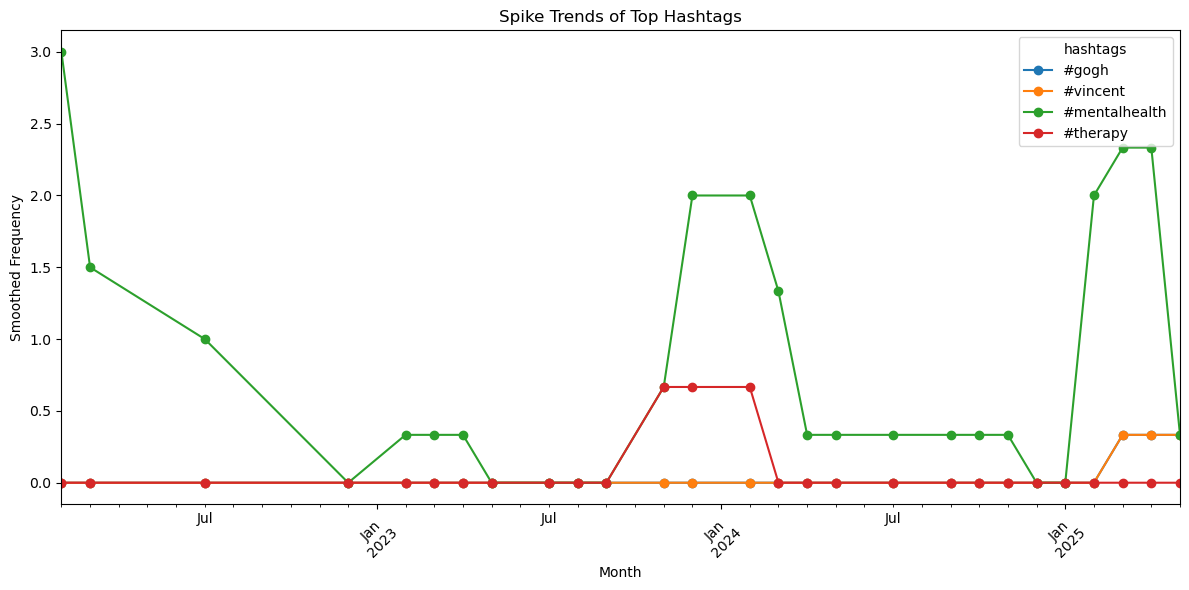

In [85]:
top_spike_tags = ['#gogh', '#vincent', '#mentalhealth','#therapy']  # replace with real spikes
smoothed[top_spike_tags].plot(figsize=(12, 6), marker='o')
plt.title("Spike Trends of Top Hashtags")
plt.xlabel("Month")
plt.ylabel("Smoothed Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
